# INSTRUCTIONS


Copy this notebook to your Google Colab

Mount your Google Drive

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
# general path:
data_path = "/content/gdrive/My Drive/data/"

Follow the directions from [here](https://mtl.yyliu.net/download/) to download the miniImageNet dataset. You should download 3 .tar files: train.tar, val.tar and test.tar.

Put them in the ```/content/gdrive/My\ Drive/data/miniImageNet/``` folder on your Google Drive. If you don't have such folder, create it first.

Move to that folder:

In [3]:
# go to the folder:
%cd /content/gdrive/My\ Drive/data
# print out the content of the folder:
%ls

/content/gdrive/My Drive/data
Flowers/       MNIST/          models/         txtdata/
miniImageNet/  mnist_model.pt  train_subsets/


Now untar the files. This might take few minutes.

Confirm correct creation of 3 folders (train, test and val):

In [4]:
%ls

Flowers/       MNIST/          models/         txtdata/
miniImageNet/  mnist_model.pt  train_subsets/


Imports:

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import torchvision.transforms as transforms
from torchvision import datasets
import os
import cv2

import numpy as np
import matplotlib.pyplot as plt
import random
from PIL import Image

train_dir = '/content/gdrive/My Drive/data/train_subsets'
val_dir = '/content/gdrive/My Drive/data/train_subsets'
model_dir = '/content/gdrive/My Drive/data/models'

Create a custom dataset where you will use your text files to store information about your data.

In [6]:
# data transforms:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])



train_transform = transforms.Compose([transforms.Resize((224,224)), transforms.RandomHorizontalFlip(),
                  transforms.RandomRotation(20), transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.2, hue=0),
                  transforms.ToTensor(), normalize])


test_transform = transforms.Compose([transforms.Resize((224,224)), transforms.ToTensor(), normalize]) 


# Create your custom dataset below:
class AntarcticPlotDataset(Dataset):
    
    #initializing the master array
    newdata = []
    
    def __init__(self, txt_file, root_dir, transform=None):
        
        
        #directory where all the images are
        self.root_dir = root_dir
        
        #transforms to do on the images
        self.transform = transform
        
        #init
        self.newdata = []
        
        
        #counter for next() method, no longer used
        self.counter = -1
        
        #text file w/ target data for the images
        photoData = txt_file
        
        
        #reading the text file line by line 
        
        for line in open(photoData):
            info = line

    
            infolist = info.split(" ")
            
            #data from one line
            finaldata = []
            
            #since all the sub images for one image rest in a master folder, need to get inside that folder
            imgname = infolist[0]
            
            #seperating the .png from the image name
            containingFolder = imgname.split("-")[0]
            
            
            #going into the folder named after the prent image
            img_dir = os.path.join(root_dir, containingFolder)           
            
            #using the text file to get the name of the image
            img = cv2.imread(os.path.join(img_dir, imgname))
    
            
            #formatting and transforming the images
            img = np.array(img)
            trans = transforms.ToPILImage()
            img = trans(img)
            #print(np.asarray(img))
            #print(img.size)
            
            
            img = self.transform(img)

            finaldata.append(img)
            
            
            
            #extracting the target data and adding it to the array for the line
            finaldata.append(int(info.split(":")[1].strip('\n')))
            
            
            #adding the information from one line to the full master array
            self.newdata.append(finaldata)


            
            
                    
    def __len__(self):
        return len(self.newdata)
    
    
    def __getitem__(self, i):
        
         #gets the ith item in newdata
        
         #error check
         if (i < 0 or i > len(self.newdata)):
            print("problem")
            return None
        
         else:
            
            #extracting image      
            img = self.newdata[i][0]
            
            #extracting target
            landmarks = (self.newdata[i][1])
            target = []
            target.append(landmarks)
            #storing both image in target in a dictionary format
            sample = {'image' : img, 'landmarks' : landmarks}
            #returning the dictionary - the enumerator wants a dictionary object
            return sample



train_rock = '/content/gdrive/My Drive/data/txtdata/trainingfiles/trainingfile_rock_small.txt'
val_rock = '/content/gdrive/My Drive/data/txtdata/valfiles/valfile_rock.txt'

train_data_rock = AntarcticPlotDataset(train_rock, train_dir, transform=train_transform)
val_data_rock = AntarcticPlotDataset(val_rock, val_dir, transform=test_transform)


In [7]:
# number of subprocesses to use for data loading
num_workers = 0 # means to use all
# how many samples per batch to load
batch_size = 7






tl_rock = torch.utils.data.DataLoader(train_data_rock, num_workers = 0, batch_size=batch_size, shuffle=False)

vl_rock = torch.utils.data.DataLoader(val_data_rock,  num_workers = 0, batch_size=batch_size)

Define the network:

We will use an existing network. Copy the ConvNet.py file from [here](https://drive.google.com/file/d/1Hf6j95u88qwJM3TnsWeiKGLTxaFHh4h4/view?usp=sharing) and put it in your "miniImageNet" folder on your Google Drive.

In [8]:
class AntarcticNet(nn.Module):
    
    
    def __init__(self):
        
        super(AntarcticNet, self).__init__()

        #planning for 3+1 stacks 
        
        #bias is default true
        
        self.conv1 = nn.Conv2d(3, 10, kernel_size = 3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(10, 16, kernel_size = 3, stride=1, padding=1)
        
        self.conv3 = nn.Conv2d(16, 24, kernel_size = 3,stride=1, padding=1)
        self.conv4 = nn.Conv2d(24, 32, kernel_size = 3, stride=1, padding=1)
        
        self.conv5 = nn.Conv2d(32, 44, kernel_size = 3, stride=1, padding=1)
        self.conv6 = nn.Conv2d(44, 64, kernel_size = 3, stride=1, padding=1)
        
        #for stack 4
        
        self.conv7 = nn.Conv2d(64, 81, kernel_size = 3, stride=1, padding=1)
        self.conv8 = nn.Conv2d(81, 96, kernel_size = 3, stride =1, padding=1)
        
        #for stack 5
        
        self.conv9 = nn.Conv2d(96, 128, kernel_size = 3, stride=1, padding=1)
        self.conv10 = nn.Conv2d(128, 128, kernel_size = 3, stride =1, padding=1)
        
        
        # lin conversion
        
        
        self.lin = nn.Linear(in_features=6272, out_features=128)
        self.lin2 = nn.Linear(in_features = 128, out_features=1)
        
        self.pool = nn.MaxPool2d(kernel_size = 3, stride=(2,2), padding=1)
        
    def forward(self, x):
        #stack 1
        x = self.conv1(x)
        x = self.conv2(x)
        x = torch.relu(self.pool(x))
        
        
        #stack 2
        
        x = self.conv3(x)
        x = self.conv4(x)
        x = torch.relu(self.pool(x))


        
        
        #stack 3
        
        x = self.conv5(x)
        x = self.conv6(x)
        x = torch.relu(self.pool(x))



        #stack 4
        x = self.conv7(x)
        x = self.conv8(x)
        x = torch.relu(self.pool(x))


        
        
        
        #stack 5
        
        x = self.conv9(x)
        x = torch.relu(self.pool(x)) #last pooling layer

        
        
        x = torch.flatten(x, start_dim=1)
        
        
        
        x = torch.relu(self.lin(x))
        return self.lin2(x)

Now let's specify the loss function that we will use.
For this reason let's adapt Contrastive Loss implemented [here](https://github.com/adambielski/siamese-triplet/blob/master/losses.py)

Let's create a function that will take our model as a parameter and will choose n images from each category and generate their embeddings (extract feature vectors that describe the images).

Let's read the information about the validation and test splits and store it in two lists:

In [17]:
rock_model = AntarcticNet()


# specify loss function
#criterion = nn.BCEWithLogitsLoss()
criterion = nn.MSELoss()
#criterion = nn.BCELoss()

# specify optimizer
optimizer = torch.optim.SGD(rock_model.parameters(), lr= 0.01, momentum=0.9)

# specify scheduler
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.1)

# save model
PATH = os.path.join(model_dir, 'rock_model.pt')
torch.save(rock_model, PATH)


# number of epochs to train the model, number of iterations per epoch
n_epochs = 20
n_iterations = int(len(train_data_rock)/batch_size)

# lists to keep track of training progress:
train_loss_progress = []
validation_accuracy_progress = []


rock_model.train()

AntarcticNet(
  (conv1): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(10, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(16, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(24, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(32, 44, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv6): Conv2d(44, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv7): Conv2d(64, 81, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv8): Conv2d(81, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv9): Conv2d(96, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (lin): Linear(in_features=6272, out_features=128, bias=True)
  (lin2): Linear(in_features=128, out_features=1, bias=True)
  (pool): MaxPool2d(kernel_size=3, stride=(2, 2), padding=1, dilation=1, ceil_mode=False)

Extract embeddings:

Let's create a testing routine to predict samples in the val/test set:

Training the network.

We will iterate through our dataset. For evey iteration we need to:


In [18]:
for epoch in range(n_epochs):
    
    # monitor training loss
    train_loss = 0.0
    
    #load the model
    
    #prep to train
    rock_model.train()
        
    
    
    for iter, D in enumerate(tl_rock):  
        
        # extracting from dictionary 
        data = D['image']
        target = D['landmarks']
        #print(type(target))
        
        #target = target[0]
        target = target.view(-1, 1)
        

        # formatting and modifying output from dict
        
        target = torch.tensor(target).float()
        #data = data.float()
                
        #### TRAINING PROPER ####
        #########################
        
        #print("Epoch:", epoch + 1, "Iteration:", iter + 1, "out of:", n_iterations)
        
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        
        # forward pass: compute predicted outputs by passing inputs to the model     
        outputs = rock_model(data)
        #print(outputs)
        
        # calculate the loss
        loss = criterion(outputs, target)
        
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        
        # perform a single optimization step (parameter update)
        optimizer.step()
        
        # update running training loss
        train_loss += loss.item()*data.size(0)
      
    #  scheduler - perform a its step in here - controls rate of learning
    scheduler.step()
    
    # print training statistics - calculate average loss over an epoch
    train_loss = train_loss/len(tl_rock.dataset)
    train_loss_progress.append(train_loss)
    print('Epoch: {} \tTraining Loss: {:.6f}'.format(epoch+1, train_loss))



    # define variables
    correct = 0
    total = 0
    
    #prep for evaluation
    rock_model.eval() 

    with torch.no_grad(): #not exactly sure what this does
        for iter, D in enumerate(vl_rock):
                        

            
            # extracting from dictionary 
            data = D['image']
            target = D['landmarks']
            
            # test prints
            
            
            
            
            # formatting data from the dict
            target = torch.tensor(target)
            
            
            # VALIDATION PROPER
            
            # returns the output if < 1, else 1 - converts output to probability
            outputs = rock_model(data)
            
            #print(outputs)
            predicted, sp = torch.max(outputs.data, 1)
            
            presize = predicted.size()
            psize = list(presize)[0]
            
            for index in range(psize):
                entry = predicted[index]
                value = entry.item()
                if (value < 0.5):
                    value = 0.0
                else:
                    value = 1.0
                predicted[index] = torch.tensor(value)
            
            
            
            # does the addition
            total += target.size(0)
            correct += (predicted == target).sum().item()
            
        validation_accuracy_progress.append(100* correct/total)


    print('Accuracy of the network on the validation set: %d %%' % (100 * correct / total))



torch.save(rock_model, PATH)

traintext.close()
valtext.close()
    

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


tensor([[-0.0409],
        [-0.0416],
        [-0.0410],
        [-0.0410],
        [-0.0412],
        [-0.0410],
        [-0.0406]], grad_fn=<AddmmBackward>)
tensor([[-0.0348],
        [-0.0350],
        [-0.0352],
        [-0.0352],
        [-0.0353],
        [-0.0347],
        [-0.0352]], grad_fn=<AddmmBackward>)
tensor([[-0.0106],
        [-0.0107],
        [-0.0105],
        [-0.0106],
        [-0.0107],
        [-0.0107],
        [-0.0105]], grad_fn=<AddmmBackward>)
tensor([[0.0200],
        [0.0201],
        [0.0201],
        [0.0198],
        [0.0199],
        [0.0201],
        [0.0204]], grad_fn=<AddmmBackward>)
tensor([[0.0633],
        [0.0635],
        [0.0638],
        [0.0633],
        [0.0632],
        [0.0629],
        [0.0637]], grad_fn=<AddmmBackward>)
tensor([[0.1026],
        [0.1021],
        [0.1021],
        [0.1024],
        [0.1019],
        [0.1021],
        [0.1018]], grad_fn=<AddmmBackward>)
tensor([[0.1492],
        [0.1511],
        [0.1501],
        [0.14

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:85: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Accuracy of the network on the validation set: 41 %
tensor([[0.1992],
        [0.2012],
        [0.1987],
        [0.1994],
        [0.1998],
        [0.1997],
        [0.1993]], grad_fn=<AddmmBackward>)
tensor([[0.2440],
        [0.2432],
        [0.2436],
        [0.2448],
        [0.2444],
        [0.2440],
        [0.2434]], grad_fn=<AddmmBackward>)
tensor([[0.2942],
        [0.2943],
        [0.2943],
        [0.2971],
        [0.2946],
        [0.2949],
        [0.2961]], grad_fn=<AddmmBackward>)
tensor([[0.3416],
        [0.3404],
        [0.3423],
        [0.3400],
        [0.3407],
        [0.3425],
        [0.3461]], grad_fn=<AddmmBackward>)
tensor([[0.3936],
        [0.3930],
        [0.3947],
        [0.3924],
        [0.3918],
        [0.3905],
        [0.3941]], grad_fn=<AddmmBackward>)
tensor([[0.4318],
        [0.4296],
        [0.4301],
        [0.4313],
        [0.4286],
        [0.4296],
        [0.4285]], grad_fn=<AddmmBackward>)
tensor([[0.4695],
        [0.4761],


After training, test the model on the test set. Write the code for it below. Use the example of validation set as your reference.

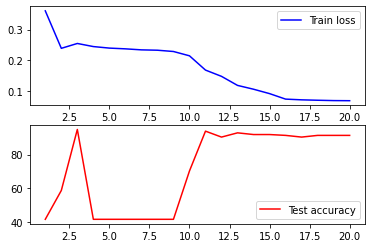

In [19]:
x_range = np.arange(1, n_epochs+1)
fig, axs = plt.subplots(2)
axs[0].plot(x_range, train_loss_progress, c='b', label="Train loss")
axs[1].plot(x_range, validation_accuracy_progress, c='r', label="Test accuracy")
axs[0].legend()
axs[1].legend()
plt.show()

In [ ]:
print("net 2 out of 10: soil")


train_soil = os.path.join(tf_dir, 'trainingfile_soil.txt')
val_soil = os.path.join(vf_dir, 'valfile_soil.txt')

traintext = open(train_soil, "r")
valtext = open(val_soil, "r")


# define datasets:

train_data_soil = AntarcticPlotDataset(traintext, train_dir, transform=train_transform)
val_data_soil = AntarcticPlotDataset(valtext, val_dir, transform=test_transform)


#test_data = datasets.ImageFolder("./output_data_rocks", transform=test_transform)

# load the data in batches: 

tl_soil = torch.utils.data.DataLoader(train_data_soil, num_workers = 0, batch_size=batch_size, shuffle=False)

vl_soil = torch.utils.data.DataLoader(val_data_soil,  num_workers = 0, batch_size=batch_size)


soil_model = AntarcticNet()


# save model
PATH = os.path.join(model_dir, 'soil_model.pt')
torch.save(soil_model, PATH)


# number of epochs to train the model, number of iterations per epoch
n_iterations = int(len(train_data_soil)/batch_size)

# lists to keep track of training progress:
train_loss_progress = []
validation_accuracy_progress = []



In [ ]:
for epoch in range(n_epochs):
    
    # monitor training loss
    train_loss = 0.0
    
    #load the model
    
    #prep to train
    soil_model.train()
        
    
    
    for iter, D in enumerate(tl_soil):  
        
        # extracting from dictionary 
        data = D['image']
        target = D['landmarks']
        #print(type(target))
        
        #target = target[0]
        target = target.view(-1, 1)
        

        # formatting and modifying output from dict
        
        target = torch.tensor(target).float()
        #data = data.float()
                
        #### TRAINING PROPER ####
        #########################
        
        #print("Epoch:", epoch + 1, "Iteration:", iter + 1, "out of:", n_iterations)
        
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        
        # forward pass: compute predicted outputs by passing inputs to the model     
        outputs = soil_model(data)
        #print(outputs)
        
        # calculate the loss
        loss = criterion(outputs, target)
        
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        
        # perform a single optimization step (parameter update)
        optimizer.step()
        
        # update running training loss
        train_loss += loss.item()*data.size(0)
      
    #  scheduler - perform a its step in here - controls rate of learning
    scheduler.step()
    
    # print training statistics - calculate average loss over an epoch
    train_loss = train_loss/len(tl_soil.dataset)
    train_loss_progress.append(train_loss)
    print('Epoch: {} \tTraining Loss: {:.6f}'.format(epoch+1, train_loss))



    # define variables
    correct = 0
    total = 0
    
    #prep for evaluation
    soil_model.eval() 

    with torch.no_grad(): #not exactly sure what this does
        for iter, D in enumerate(vl_rock):
                        

            
            # extracting from dictionary 
            data = D['image']
            target = D['landmarks']
            
            # test prints
            
            
            
            
            # formatting data from the dict
            target = torch.tensor(target)
            
            
            # VALIDATION PROPER
            
            # returns the output if < 1, else 1 - converts output to probability
            outputs = soil_model(data)
            
            #print(outputs)
            predicted, sp = torch.max(outputs.data, 1)
            
            presize = predicted.size()
            psize = list(presize)[0]
            
            for index in range(psize):
                entry = predicted[index]
                value = entry.item()
                if (value < 0.5):
                    value = 0.0
                else:
                    value = 1.0
                predicted[index] = torch.tensor(value)
            
            
            
            # does the addition
            total += target.size(0)
            correct += (predicted == target).sum().item()
            
        validation_accuracy_progress.append(100* correct/total)


    print('Accuracy of the network on the validation set: %d %%' % (100 * correct / total))



torch.save(soil_model, PATH)

traintext.close()
valtext.close()
    

In [ ]:
x_range = np.arange(1, n_epochs+1)
fig, axs = plt.subplots(2)
axs[0].plot(x_range, train_loss_progress, c='b', label="Train loss")
axs[1].plot(x_range, validation_accuracy_progress, c='r', label="Test accuracy")
axs[0].legend()
axs[1].legend()
plt.show()